# Ferramenta para Previsão de Preço de Imóvel - Projeto Airbnb para a cidade do Rio de Janeiro

### Objetivo

Construir uma proposta de modelo de previsão de preço que permita uma pessoa comum que possui um imóvel, possa saber quanto deve cobrar pela diária do seu imóvel.

Ou ainda, para o locador comum, dado o imóvel que ele está buscando, ajudar a saber se aquele imóvel está com preço atrativo (abaixo da média para imóveis com as mesmas características) ou não.

### As bases de dados foram retiradas do site kaggle: https://www.kaggle.com/allanbruno/airbnb-rio-de-janeiro

- As bases de dados são os preços dos imóveis obtidos e suas respectivas características em cada mês.
- A moeda utilizada é o Real (R$)
- Temos bases de abril de 2018 a maio de 2020, com exceção de junho de 2018 que não possui base de dados

### Expectativas Iniciais

- Acredito que a sazonalidade pode ser um fator importante, visto que meses como dezembro costumam ser altos no Rio de Janeiro.
- A localização do imóvel provavelmente fará muita diferença no preço, já que no Rio de Janeiro a localização pode mudar completamente as características do lugar (segurança, beleza natural, pontos turísticos).
- Adicionais/Comodidades podem ter um impacto significativo, visto que temos muitos prédios e casas antigos no Rio de Janeiro.

Vamos descobrir o quanto esses fatores impactam e se temos outros fatores não tão intuitivos que são extremamente importantes.

### Importar Bibliotecas e Bases de Dados

In [2]:
import pandas as pd
import pathlib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [3]:
meses = {'jan': 1, 'fev': 2, 'mar': 3, 'abr': 4, 'mai': 5, 'jun': 6, 'jul': 7, 'ago': 8, 'set': 9, 'out': 10, 'nov': 11, 'dez': 12}
caminho_bases = pathlib.Path('dataset')

base_airbnb = pd.DataFrame()

for arquivo in caminho_bases.iterdir():
    nome_mes = arquivo.name[:3]
    mes = meses[nome_mes]
    ano = arquivo.name[-8:]
    ano = int(ano.replace('.csv', ''))
    df = pd.read_csv(caminho_bases / arquivo.name)
    df['ano'] = ano
    df['mes'] = mes    
    base_airbnb = base_airbnb.append(df)
    
display(base_airbnb)


access  accommodates  \
0                                                    NaN             4   
1      The entire apartment is yours. It is a vacatio...             5   
2      From the International airport, take a  regula...             2   
3      internet wi-fi, cable tv, air cond, ceiling fa...             3   
4      Die Urlauber dürfen das Badezimmer benutzen, d...             3   
5                                                    NaN             3   
6      Our guests have quick access to the beach and ...             2   
7      You 'll have an access to 1 or 2 bedrooms 1 pr...             3   
8                                                    NaN             3   
9      Entire private unit, 7 bedrooms and terrace. N...            14   
10     Os hospedes tem acesso a lavanderia, cozinha p...             1   
11     A praia de Copacabana está distante a poucos p...            11   
12                                                   NaN             3   
13     Entire private unit, for the guest's sole use....             8   
14                                                   NaN             4   
15     Kitchen (full acesorized)  Terrace  Garden lak...            12   
16     It´s a private apt, so  you will not share wit...             2   
17       All Guest have access to Joatinga beach.  Th...            10   
18                      the guest will have his own key.             1   
19     The address is Rua Buarque de Macedo N° 15 apt...             6   
20                         Copule bed and 2 Singles beds             4   
21                                  The entire apartment             4   
22     Entire private unit, for the guest's sole use....             6   
23                                                   NaN             2   
24     Ironing board and hair dryer are available.  L...             2   
25                        Entire and exclusive apartment             4   
26     wifi, 24h reception, pool, sauna, garage, diar...             5   
27     We are renting a private room (with private ba...             2   
28                                                   NaN             2   
29     As áreas comuns são piscina e churrasqueira de...             2   
...                                                  ...           ...   
34299                                                NaN             2   
34300      You´ll have the whole apartment for yourself!             6   
34301                                                NaN             4   
34302                                                NaN             2   
34303                                                NaN             4   
34304                                                NaN             2   
34305                                                NaN             2   
34306                                                NaN             2   
34307                                                NaN             5   
34308                                                NaN             1   
34309                                                NaN             4   
34310                                                NaN             2   
34311                                                NaN            14   
34312                                                NaN             2   
34313                                                NaN             8   
34314  Toda área do apartamento e mais a pequena  áre...             4   
34315                                                NaN             5   
34316                                                NaN             1   
34317                                                NaN             4   
34318                                                NaN             4   
34319                                                NaN             4   
34320                                                NaN             4   
34321                                                N

### Consolidando a Base de Dados

In [4]:
print(list(base_airbnb.columns))
base_airbnb.head(1000).to_csv('primeiros_registros.csv', sep=';')

['access', 'accommodates', 'amenities', 'ano', 'availability_30', 'availability_365', 'availability_60', 'availability_90', 'bathrooms', 'bed_type', 'bedrooms', 'beds', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms', 'calendar_last_scraped', 'calendar_updated', 'cancellation_policy', 'city', 'cleaning_fee', 'country', 'country_code', 'description', 'experiences_offered', 'extra_people', 'first_review', 'guests_included', 'has_availability', 'host_about', 'host_acceptance_rate', 'host_has_profile_pic', 'host_id', 'host_identity_verified', 'host_is_superhost', 'host_listings_count', 'host_location', 'host_name', 'host_neighbourhood', 'host_picture_url', 'host_response_rate', 'host_response_time', 'host_since', 'host_thumbnail_url', 'host_total_listings_count', 'host_url', 'host_verifications', 'house_rules', 'id', 'instant_bookable', 'interaction', 'is_business_

### Limpando e Tratando quais as features relevantes para o modelo

In [5]:
colunas = ['host_response_time','host_response_rate','host_is_superhost','host_listings_count','latitude','longitude','property_type','room_type','accommodates','bathrooms','bedrooms','beds','bed_type','amenities','price','security_deposit','cleaning_fee','guests_included','extra_people','minimum_nights','maximum_nights','number_of_reviews','review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value','instant_bookable','is_business_travel_ready','cancellation_policy','ano','mes']
base_airbnb = base_airbnb.loc[:, colunas]
display(base_airbnb)

host_response_time host_response_rate host_is_superhost  \
0                     NaN                NaN                 f   
1          within an hour               100%                 t   
2          within an hour               100%                 f   
3          within an hour               100%                 f   
4          within an hour               100%                 t   
5          within an hour               100%                 t   
6          within an hour               100%                 t   
7            within a day                50%                 f   
8      within a few hours               100%                 f   
9          within an hour                94%                 f   
10         within an hour               100%                 t   
11         within an hour               100%                 f   
12     within a few hours                90%                 f   
13         within an hour                94%                 f   
14     within a few hours               100%                 f   
15           within a day                70%                 f   
16         within an hour               100%                 t   
17           within a day               100%                 f   
18     within a few hours               100%                 f   
19     within a few hours               100%                 f   
20                    NaN                NaN                 f   
21                    NaN                NaN                 f   
22         within an hour                94%                 f   
23         within an hour                96%                 t   
24                    NaN                NaN                 f   
25         within an hour               100%                 f   
26         within an hour               100%                 t   
27     a few days or more                 0%                 f   
28         within an hour               100%                 f   
29           within a day               100%                 f   
...                   ...                ...               ...   
34299  a few days or more                37%                 f   
34300      within an hour               100%                 t   
34301                 NaN                NaN                 f   
34302  a few days or more                37%                 f   
34303      within an hour                96%                 f   
34304        within a day                57%                 f   
34305      within an hour               100%                 t   
34306      within an hour                98%                 f   
34307  a few days or more                38%                 f   
34308                 NaN                NaN                 f   
34309      within an hour                97%                 t   
34310      within an hour               100%                 f   
34311      within an hour               100%                 f   
34312      within an hour               100%                 f   
34313  within a few hours               100%                 f   
34314                 NaN                NaN                 f   
34315  a few days or more                38%                 f   
34316                 NaN                NaN                 f   
34317  within a few hours               100%                 t   
34318      within an hour                93%                 f   
34319      within an hour                93%                 f   
34320      within an hour                93%                 f   
34321                 NaN                NaN                 f   
34322      within an hour               100%                 f   
34323                 NaN                NaN                 f   
34324      within an hour                93%                 f   
34325                 NaN                NaN                 f   
34326  within a few hours                74%                 f   
34327                 NaN                NaN   

### Tratando Valores Missing

In [8]:
for coluna in base_airbnb:
    if base_airbnb[coluna].isnull().sum() > 300000:
        base_airbnb = base_airbnb.drop(coluna, axis=1)

print(base_airbnb.isnull().sum())
base_airbnb = base_airbnb.dropna()
print(base_airbnb.shape)

host_is_superhost           0
host_listings_count         0
latitude                    0
longitude                   0
property_type               0
room_type                   0
accommodates                0
bathrooms                   0
bedrooms                    0
beds                        0
bed_type                    0
amenities                   0
price                       0
guests_included             0
extra_people                0
minimum_nights              0
maximum_nights              0
number_of_reviews           0
instant_bookable            0
is_business_travel_ready    0
cancellation_policy         0
ano                         0
mes                         0
dtype: int64
(897709, 23)


### Verificação e Tratamento dos tipos de dados em cada feature

In [9]:
print(base_airbnb.dtypes)
print('-'*45)
print(base_airbnb.iloc[0])

host_is_superhost            object
host_listings_count         float64
latitude                    float64
longitude                   float64
property_type                object
room_type                    object
accommodates                  int64
bathrooms                   float64
bedrooms                    float64
beds                        float64
bed_type                     object
amenities                    object
price                        object
guests_included               int64
extra_people                 object
minimum_nights                int64
maximum_nights                int64
number_of_reviews             int64
instant_bookable             object
is_business_travel_ready     object
cancellation_policy          object
ano                           int64
mes                           int64
dtype: object
---------------------------------------------
host_is_superhost                                                           f
host_listings_count               

In [10]:
#PRICE
base_airbnb['price'] = base_airbnb['price'].str.replace('$', '')
base_airbnb['price'] = base_airbnb['price'].str.replace(',', '')
base_airbnb['price'] = base_airbnb['price'].astype(np.float32, copy = False)
#EXTRA_PEOPLE
base_airbnb['extra_people'] = base_airbnb['extra_people'].str.replace('$', '')
base_airbnb['extra_people'] = base_airbnb['extra_people'].str.replace(',', '')
base_airbnb['extra_people'] = base_airbnb['extra_people'].astype(np.float32, copy = False)
#VERIFICANDO OS TIPOS
print(base_airbnb.dtypes)

host_is_superhost            object
host_listings_count         float64
latitude                    float64
longitude                   float64
property_type                object
room_type                    object
accommodates                  int64
bathrooms                   float64
bedrooms                    float64
beds                        float64
bed_type                     object
amenities                    object
price                       float32
guests_included               int64
extra_people                float32
minimum_nights                int64
maximum_nights                int64
number_of_reviews             int64
instant_bookable             object
is_business_travel_ready     object
cancellation_policy          object
ano                           int64
mes                           int64
dtype: object


### Análise Exploratória e Tratar os Outliers

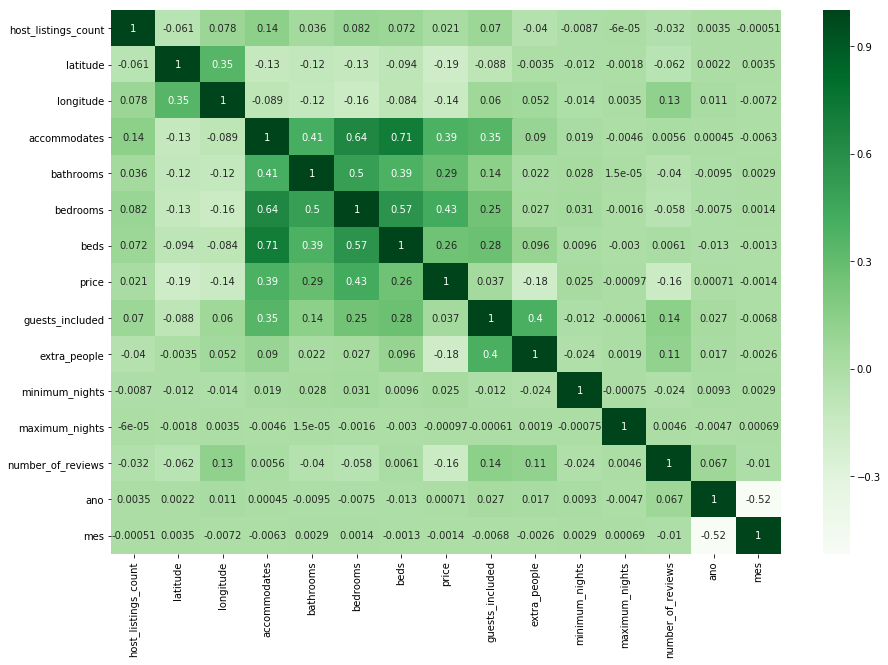

In [22]:
plt.figure(figsize=(15, 10))
sns.heatmap(base_airbnb.corr(), annot=True, cmap='Greens')



#### Funções para análise dos Outliers

In [13]:
def limites(coluna):
    q1 = coluna.quantile(0.25)
    q3 = coluna.quantile(0.75)
    amplitude = q3 - q1
    return q1 - 1.5 * amplitude, q3 + 1.5 * amplitude

def excluir_outliers(df, nome_coluna):
    qtde_linhas = df.shape[0]
    lim_inf, lim_sup = limites(df[nome_coluna])
    df = df.loc[(df[nome_coluna] >= lim_inf) & (df[nome_coluna] <= lim_sup), :]
    linhas_removidas = qtde_linhas - df.shape[0]
    return df, linhas_removidas

In [14]:
def diagrama_caixa(coluna):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(15, 5)
    sns.boxplot(x=coluna, ax=ax1)
    ax2.set_xlim(limites(coluna))
    sns.boxplot(x=coluna, ax=ax2)
    
def histograma(coluna):
    plt.figure(figsize=(15, 5))
    sns.distplot(coluna, hist=True)
    
def grafico_barra(coluna):
    plt.figure(figsize=(15, 5))
    ax = sns.barplot(x=coluna.value_counts().index, y=coluna.value_counts())
    ax.set_xlim(limites(coluna))

#### PRICE

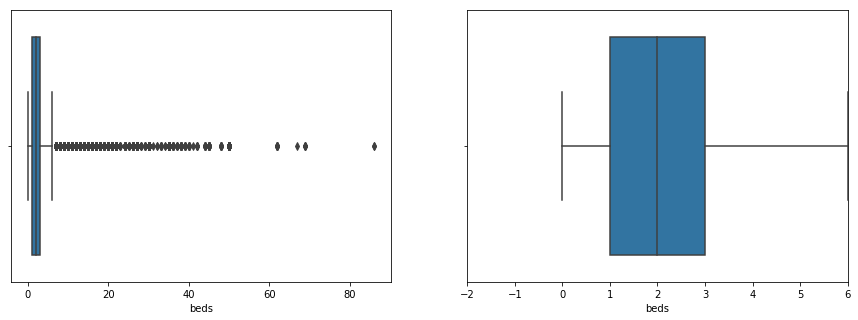

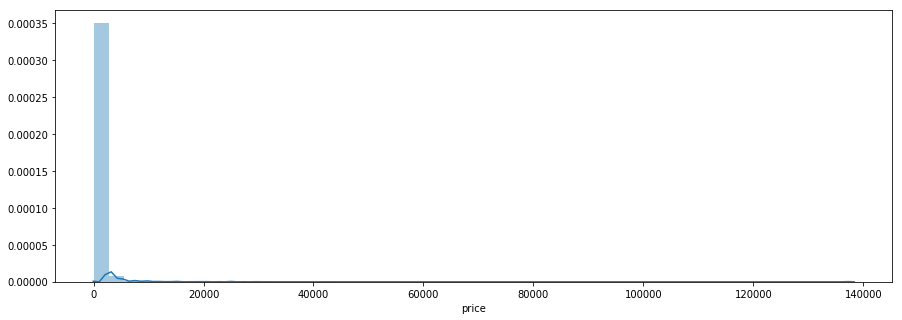

In [16]:
diagrama_caixa(base_airbnb['beds'])
histograma(base_airbnb['price'])

In [17]:
#Como a construção do modelo é para imóveis comuns, creio que os valores acima do limite superior representam imóveis
#de altíssimo padrão e, como não é o nosso objetivo principal. Por isso vou excluir esses outliers.

In [18]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'price')
print('{} linhas removidas'.format(linhas_removidas))

87282 linhas removidas


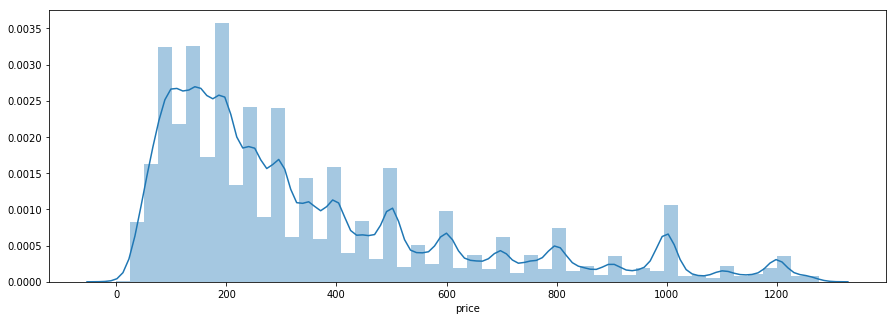

In [19]:
histograma(base_airbnb['price'])

#### EXTRA-PEOPLE

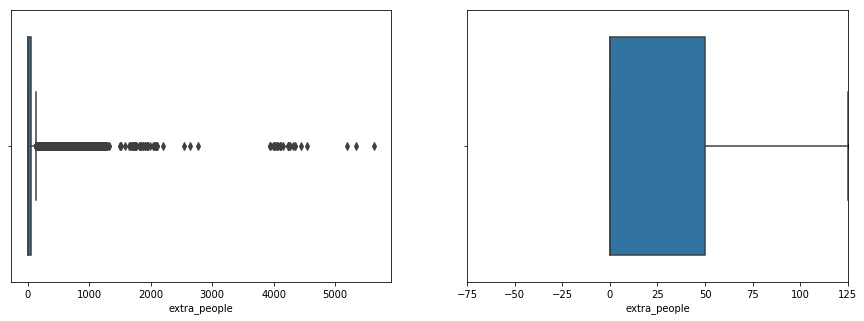

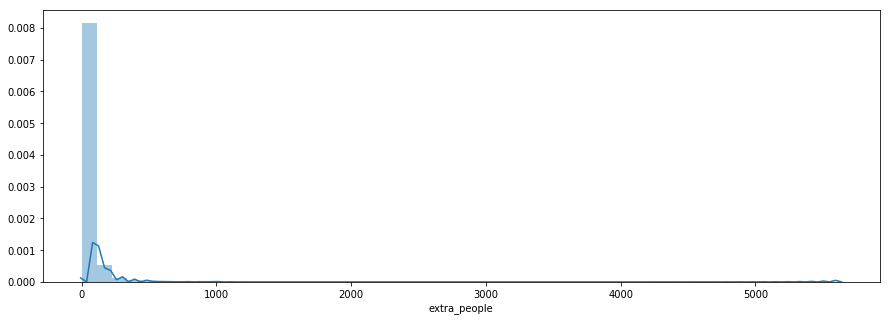

In [20]:
diagrama_caixa(base_airbnb['extra_people'])
histograma(base_airbnb['extra_people'])

In [21]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'extra_people')
print('{} linhas removidas'.format(linhas_removidas))

59194 linhas removidas


#### HOST LISTINGS COUNT 

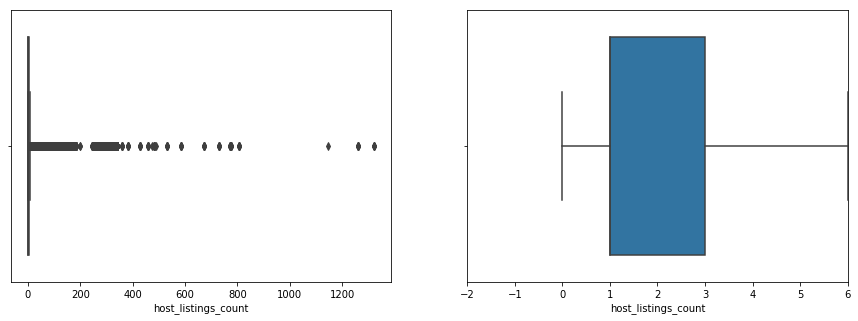

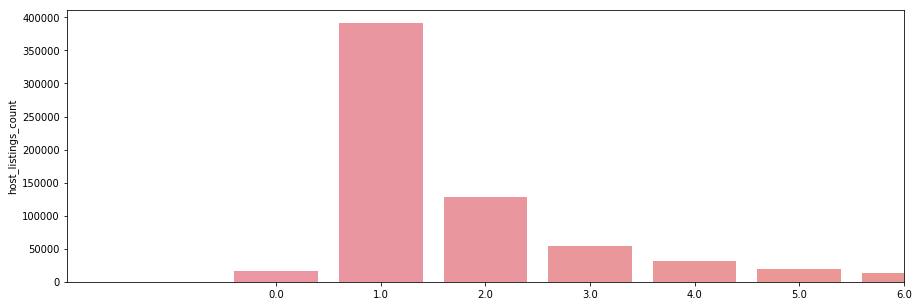

In [23]:
diagrama_caixa(base_airbnb['host_listings_count'])
grafico_barra(base_airbnb['host_listings_count'])

Excluindo os outliers do projeto, pois os host com mais de 6 imoveis no airbnb não são o público alvo.


In [24]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'host_listings_count')
print('{} linhas removidas'.format(linhas_removidas))

97723 linhas removidas


#### ACCOMMODATES

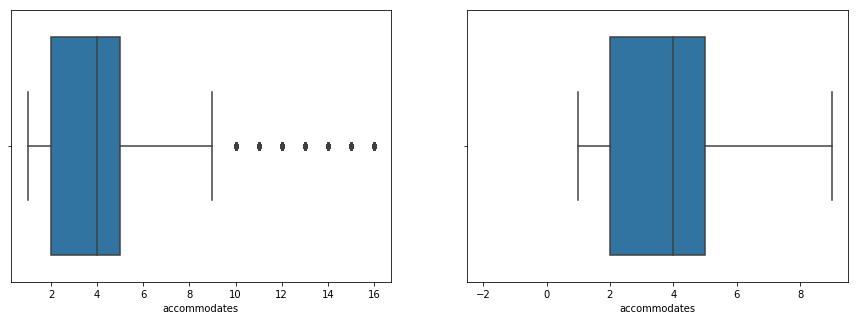

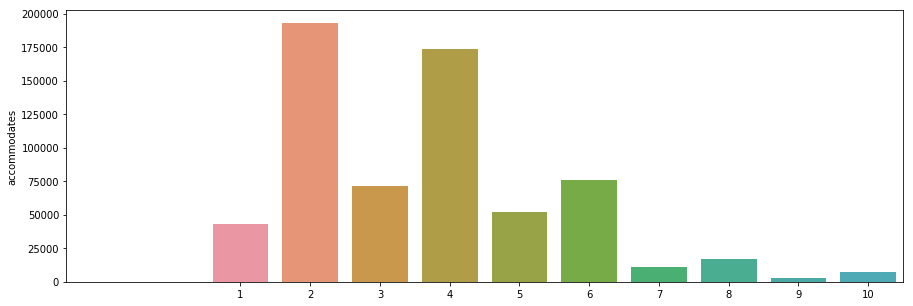

In [25]:
diagrama_caixa(base_airbnb['accommodates'])
grafico_barra(base_airbnb['accommodates'])

In [26]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'accommodates')
print('{} linhas removidas'.format(linhas_removidas))

13146 linhas removidas


#### BATHROOMS

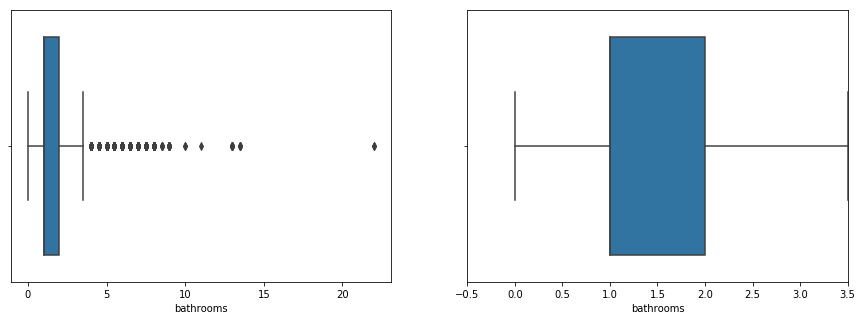

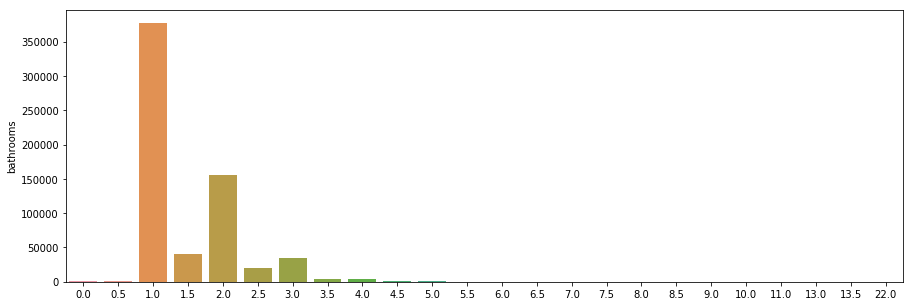

In [27]:
diagrama_caixa(base_airbnb['bathrooms'])
plt.figure(figsize=(15, 5))
sns.barplot(x=base_airbnb['bathrooms'].value_counts().index, y=base_airbnb['bathrooms'].value_counts())

In [28]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'bathrooms')
print('{} linhas removidas'.format(linhas_removidas))

6894 linhas removidas


#### BEDROOMS

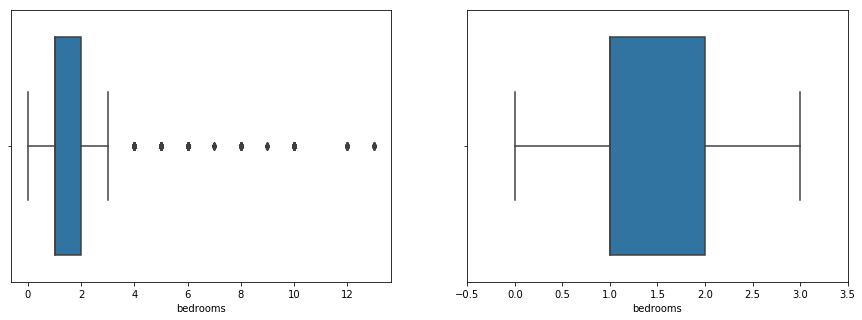

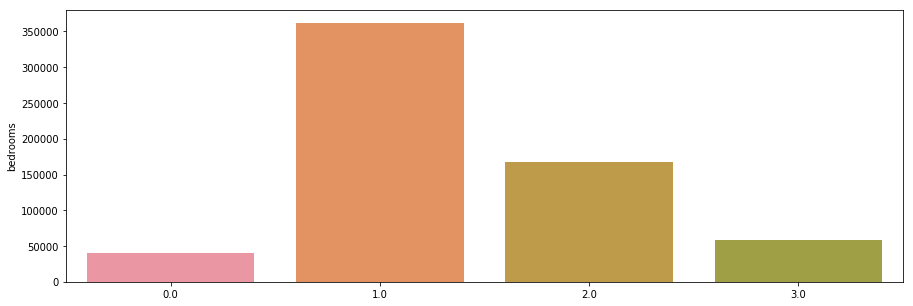

In [29]:
diagrama_caixa(base_airbnb['bedrooms'])
grafico_barra(base_airbnb['bedrooms'])

In [30]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'bedrooms')
print('{} linhas removidas'.format(linhas_removidas))

5482 linhas removidas


#### BEDS  

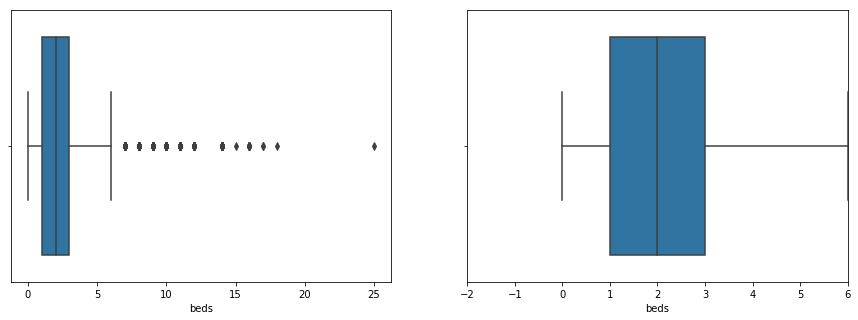

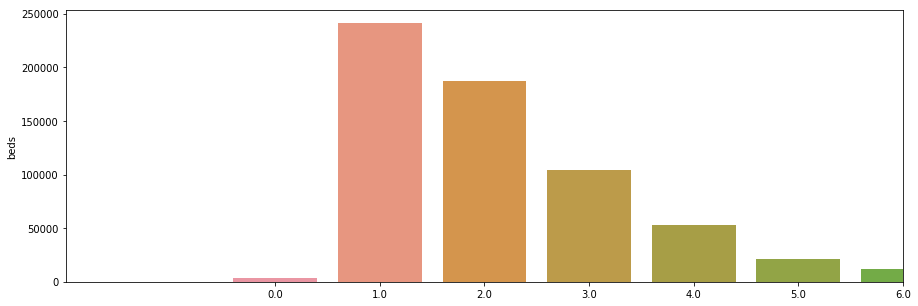

In [31]:
diagrama_caixa(base_airbnb['beds'])
grafico_barra(base_airbnb['beds'])

In [32]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'beds')
print('{} linhas removidas'.format(linhas_removidas))

5622 linhas removidas


#### GUESTS INCLUDED

(1.0, 1.0)


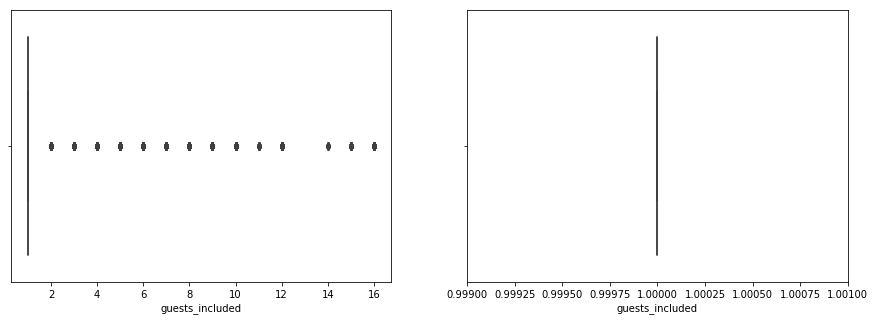

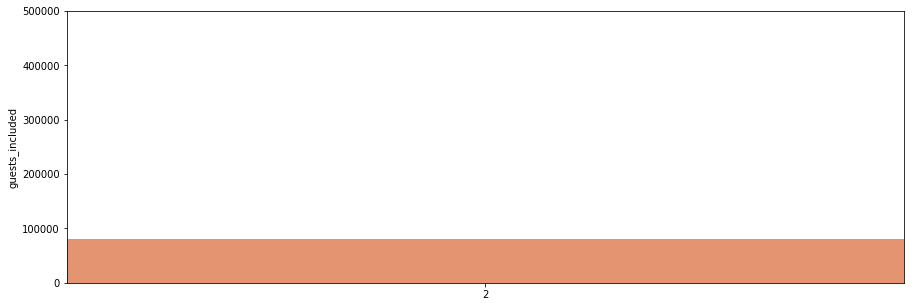

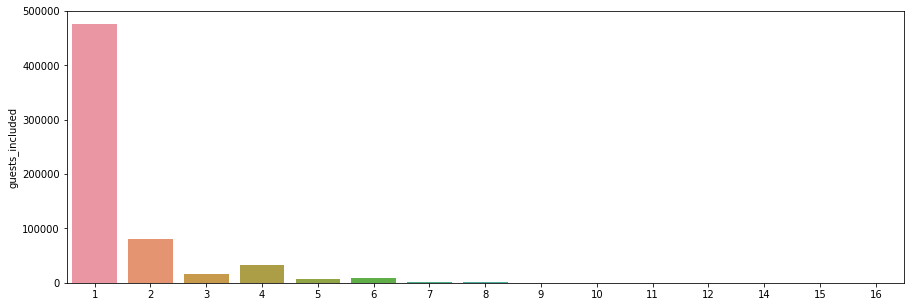

In [33]:
diagrama_caixa(base_airbnb['guests_included'])
grafico_barra(base_airbnb['guests_included'])
print(limites(base_airbnb['guests_included']))
plt.figure(figsize=(15, 5))
sns.barplot(x=base_airbnb['guests_included'].value_counts().index, y=base_airbnb['guests_included'].value_counts())


Vou remover essa feature dessa análise. Provavelmente os usuiários do airbnb não usam muito de forma correta esse preenchimento e acabam colocando o valor padrão do airbnb com 1 para "guests_included". Isso pode deixar o modelo a considerar essa feature "não essencial" como base para análise de preços.

In [34]:
base_airbnb = base_airbnb.drop('guests_included', axis=1)
base_airbnb.shape

(622366, 22)

#### MINIMUM NIGHTS 

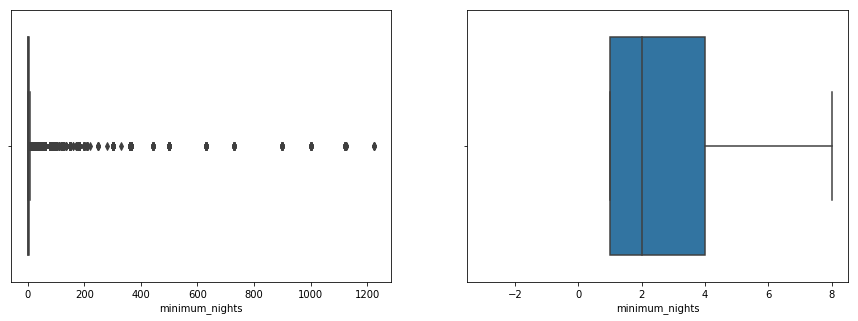

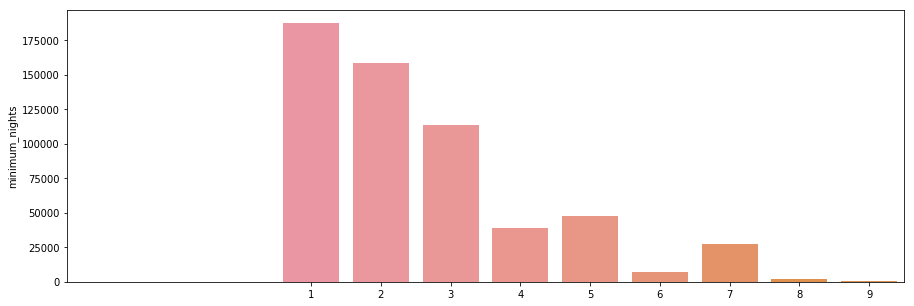

In [35]:
diagrama_caixa(base_airbnb['minimum_nights'])
grafico_barra(base_airbnb['minimum_nights'])

In [36]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'minimum_nights')
print('{} linhas removidas'.format(linhas_removidas))

40383 linhas removidas


#### MAXIMUM NIGHTS

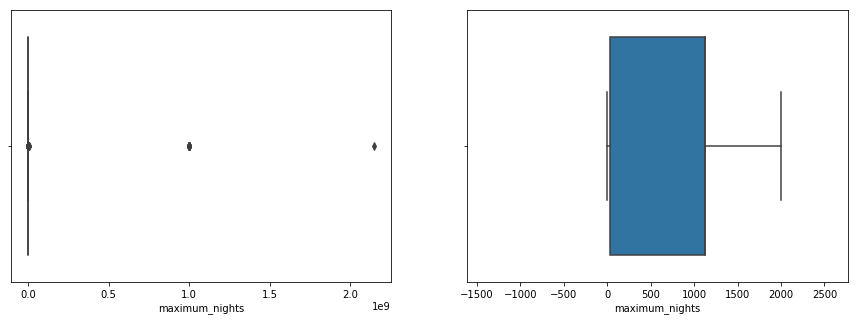

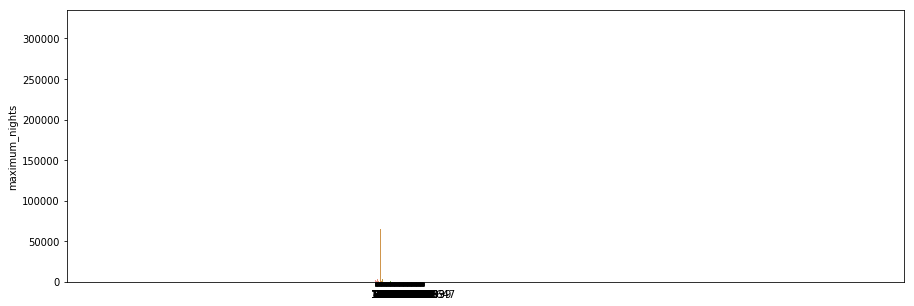

In [37]:
diagrama_caixa(base_airbnb['maximum_nights'])
grafico_barra(base_airbnb['maximum_nights'])

In [38]:
base_airbnb = base_airbnb.drop('maximum_nights', axis=1)
base_airbnb.shape

(581983, 21)

#### NUMBER OF REVIEWS


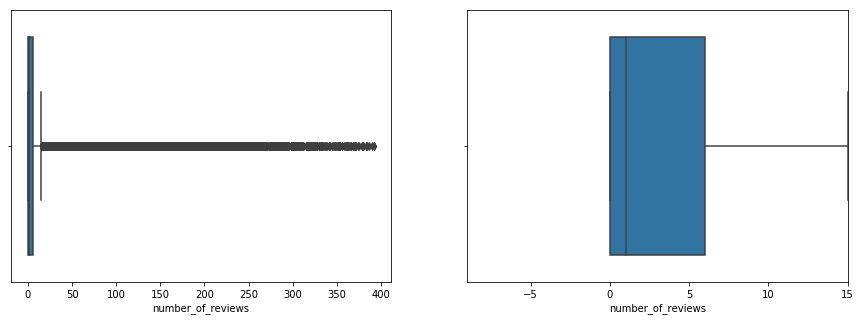

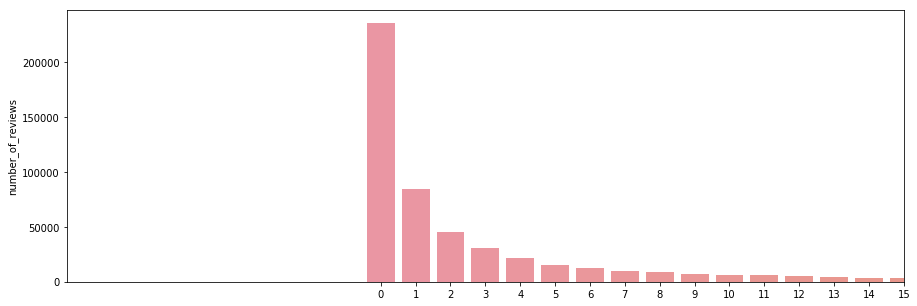

In [39]:
diagrama_caixa(base_airbnb['number_of_reviews'])
grafico_barra(base_airbnb['number_of_reviews'])

In [40]:
base_airbnb = base_airbnb.drop('number_of_reviews', axis=1)
base_airbnb.shape

(581983, 20)

### Tratamento de features de texto (strings)

#### PROPERTY TYPE

Apartment                 458354
House                      51387
Condominium                26456
Serviced apartment         12671
Loft                       12352
Guest suite                 3621
Bed and breakfast           3472
Hostel                      2665
Guesthouse                  2155
Other                       1957
Villa                       1294
Townhouse                    969
Aparthotel                   693
Chalet                       481
Earth house                  468
Tiny house                   457
Boutique hotel               447
Hotel                        376
Casa particular (Cuba)       298
Cottage                      230
Bungalow                     207
Dorm                         185
Cabin                        141
Nature lodge                 124
Castle                        80
Treehouse                     76
Island                        54
Boat                          53
Hut                           40
Campsite                      34
Resort    

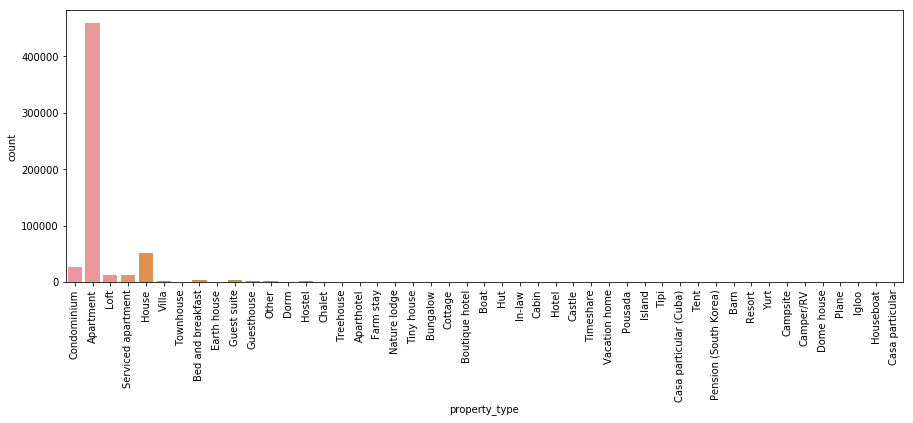

In [41]:
print(base_airbnb['property_type'].value_counts())

plt.figure(figsize=(15, 5))
grafico = sns.countplot('property_type', data=base_airbnb)
grafico.tick_params(axis='x', rotation=90)

['Other', 'Villa', 'Townhouse', 'Aparthotel', 'Chalet', 'Earth house', 'Tiny house', 'Boutique hotel', 'Hotel', 'Casa particular (Cuba)', 'Cottage', 'Bungalow', 'Dorm', 'Cabin', 'Nature lodge', 'Castle', 'Treehouse', 'Island', 'Boat', 'Hut', 'Campsite', 'Resort', 'Camper/RV', 'Yurt', 'Tent', 'Tipi', 'Barn', 'Farm stay', 'Pension (South Korea)', 'Dome house', 'Igloo', 'In-law', 'Vacation home', 'Timeshare', 'Pousada', 'Houseboat', 'Casa particular', 'Plane']
Apartment             458354
House                  51387
Condominium            26456
Serviced apartment     12671
Loft                   12352
Outros                  8850
Guest suite             3621
Bed and breakfast       3472
Hostel                  2665
Guesthouse              2155
Name: property_type, dtype: int64


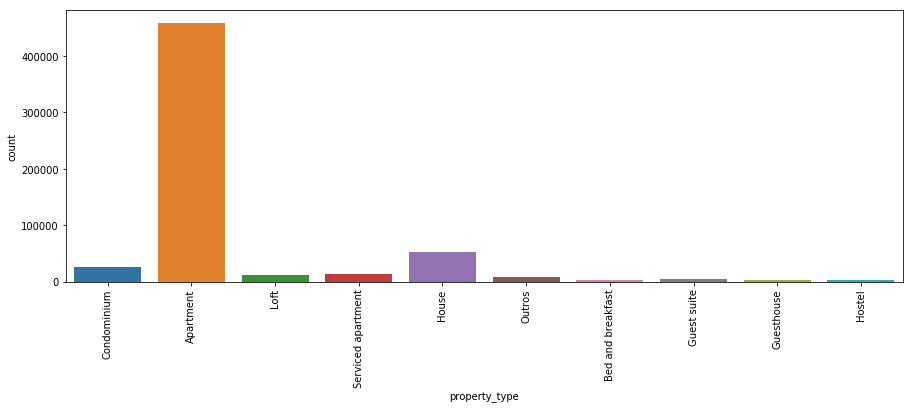

In [42]:
tabela_tipos_casa = base_airbnb['property_type'].value_counts()
colunas_agrupar = []

for tipo in tabela_tipos_casa.index:
    if tabela_tipos_casa[tipo] < 2000:
        colunas_agrupar.append(tipo)
        
print(colunas_agrupar)

for tipo in colunas_agrupar:
    base_airbnb.loc[base_airbnb['property_type'] == tipo, 'property_type'] = 'Outros'
     
print(base_airbnb['property_type'].value_counts())
plt.figure(figsize=(15, 5))
grafico = sns.countplot('property_type', data=base_airbnb)
grafico.tick_params(axis='x', rotation=90)

#### ROOM TYPE 

Entire home/apt    372443
Private room       196859
Shared room         11714
Hotel room            967
Name: room_type, dtype: int64


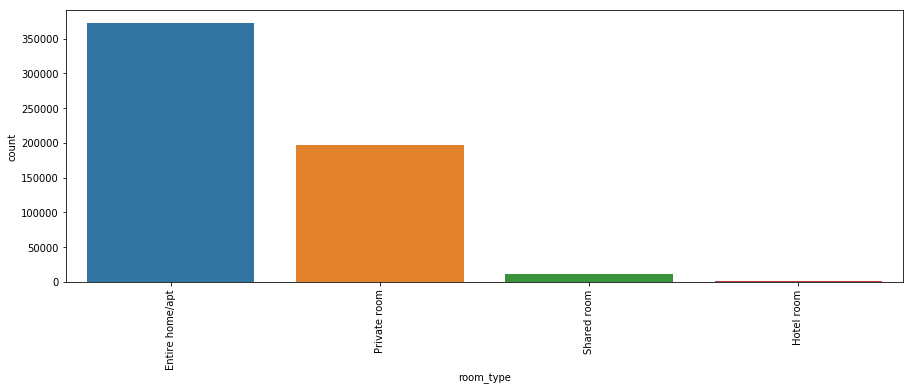

In [43]:
print(base_airbnb['room_type'].value_counts())

plt.figure(figsize=(15, 5))
grafico = sns.countplot('room_type', data=base_airbnb)
grafico.tick_params(axis='x', rotation=90)

#### BED TYPE 

Real Bed         570643
Pull-out Sofa      8055
Futon              1634
Airbed             1155
Couch               496
Name: bed_type, dtype: int64
['Pull-out Sofa', 'Futon', 'Airbed', 'Couch']
Real Bed    570643
Outros       11340
Name: bed_type, dtype: int64


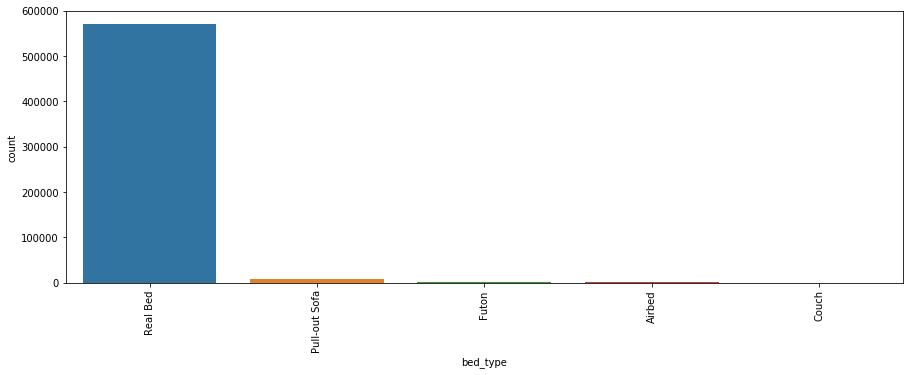

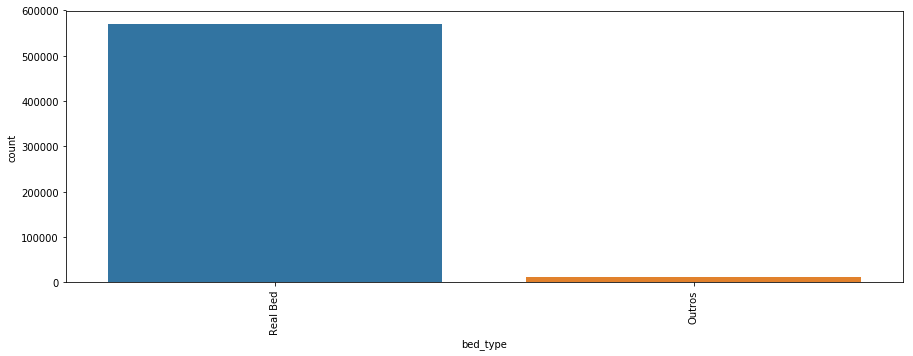

In [44]:
print(base_airbnb['bed_type'].value_counts())

plt.figure(figsize=(15, 5))
grafico = sns.countplot('bed_type', data=base_airbnb)
grafico.tick_params(axis='x', rotation=90)

#agrupando categorias de bed_type
tabela_bed = base_airbnb['bed_type'].value_counts()
colunas_agrupar = []

for tipo in tabela_bed.index:
    if tabela_bed[tipo] < 10000:
        colunas_agrupar.append(tipo)
        
print(colunas_agrupar)

for tipo in colunas_agrupar:
    base_airbnb.loc[base_airbnb['bed_type']==tipo, 'bed_type'] = 'Outros'
    
print(base_airbnb['bed_type'].value_counts())
plt.figure(figsize=(15, 5))
grafico = sns.countplot('bed_type', data=base_airbnb)
grafico.tick_params(axis='x', rotation=90)

#### CANCELLATION POLICY

flexible                       258096
strict_14_with_grace_period    200743
moderate                       113281
strict                           9696
super_strict_60                   135
super_strict_30                    32
Name: cancellation_policy, dtype: int64
['strict', 'super_strict_60', 'super_strict_30']
flexible                       258096
strict_14_with_grace_period    200743
moderate                       113281
strict                           9863
Name: cancellation_policy, dtype: int64


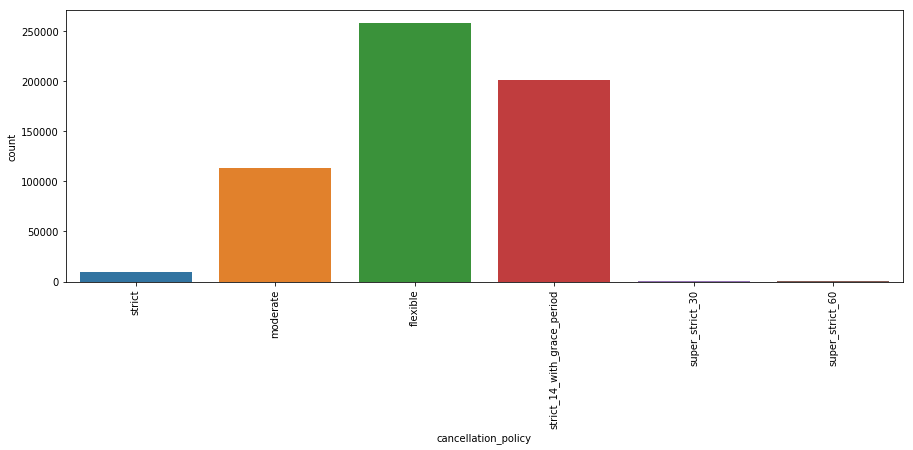

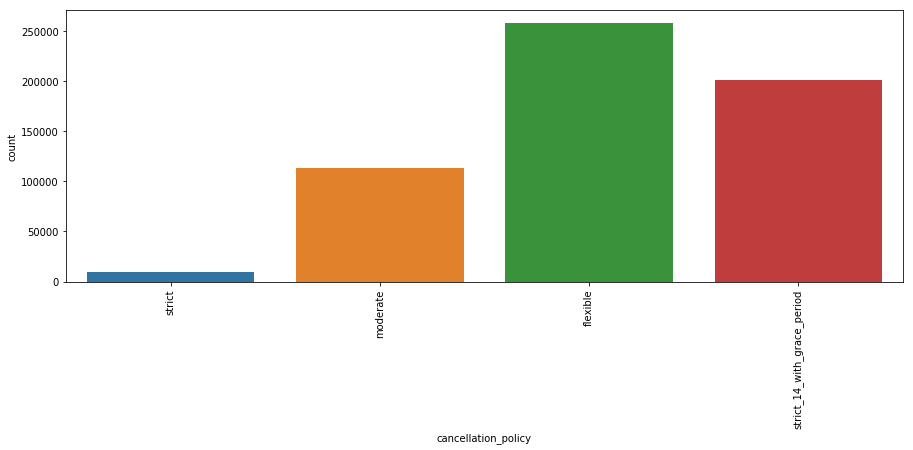

In [45]:
print(base_airbnb['cancellation_policy'].value_counts())

plt.figure(figsize=(15, 5))
grafico = sns.countplot('cancellation_policy', data=base_airbnb)
grafico.tick_params(axis='x', rotation=90)

#agrupando categorias de cancellation_policy
tabela_cancellation = base_airbnb['cancellation_policy'].value_counts()
colunas_agrupar = []

for tipo in tabela_cancellation.index:
    if tabela_cancellation[tipo] < 10000:
        colunas_agrupar.append(tipo)
        
print(colunas_agrupar)

for tipo in colunas_agrupar:
    base_airbnb.loc[base_airbnb['cancellation_policy'] == tipo, 'cancellation_policy'] = 'strict'
    
print(base_airbnb['cancellation_policy'].value_counts())
plt.figure(figsize=(15, 5))
grafico = sns.countplot('cancellation_policy', data=base_airbnb)
grafico.tick_params(axis='x', rotation=90)

#### AMENITIES          

Possuimos muita diversidade de amenities (as mesmas escritas de formas similares), vamos avaliar a quantidade de variações para o nosso modelo. 

In [46]:
print(base_airbnb['amenities'].iloc[0].split(','))
print(len(base_airbnb['amenities'].iloc[0].split(',')))

base_airbnb['n_amenities'] = base_airbnb['amenities'].str.split(',').apply(len)

['{TV', '"Cable TV"', 'Internet', 'Wifi', '"Air conditioning"', 'Kitchen', '"Paid parking off premises"', '"Smoking allowed"', 'Doorman', 'Elevator', '"Hot tub"', '"Family/kid friendly"', '"Suitable for events"', 'Essentials', '"24-hour check-in"', 'Hangers', '"Hair dryer"', 'Iron', '"Laptop friendly workspace"', '"Self check-in"', '"Front desk/doorperson"', '"Private entrance"', '"Hot water"', '"Bed linens"', '"Luggage dropoff allowed"}']
25


In [47]:
base_airbnb = base_airbnb.drop('amenities', axis=1)
base_airbnb.shape

(581983, 20)

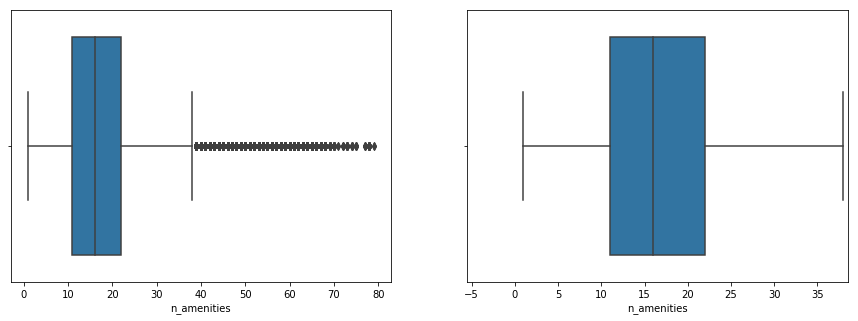

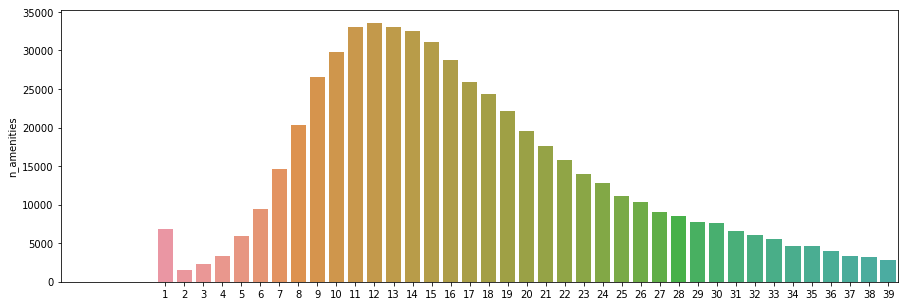

In [48]:
diagrama_caixa(base_airbnb['n_amenities'])
grafico_barra(base_airbnb['n_amenities'])

In [49]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'n_amenities')
print('{} linhas removidas'.format(linhas_removidas))

24343 linhas removidas


### VISUALIZAÇÃO DE MAPAS DE PROPRIEDADES

In [50]:
amostra = base_airbnb.sample(n=50000)
centro_mapa = {'lat':amostra.latitude.mean(), 'lon':amostra.longitude.mean()}
mapa = px.density_mapbox(amostra, lat='latitude', lon='longitude', z='price', radius = 2.5,
                        center=centro_mapa, zoom = 10,
                        mapbox_style='stamen-terrain')
mapa.show()

### Encoding

Precisamos ajustar as features para facilitar o modelo a ser treinado.
Features booleanas (T or F) serão substituídas por (1 ou 0) respectivamente.
Features de categoria (features onde as categorias são textos) vamos utilizar o método de encoding DUMMIES.

In [51]:
colunas_tf = ['host_is_superhost', 'instant_bookable', 'is_business_travel_ready']
base_airbnb_cod = base_airbnb.copy()
for coluna in colunas_tf:
    base_airbnb_cod.loc[base_airbnb_cod[coluna] == 't', coluna] = 1
    base_airbnb_cod.loc[base_airbnb_cod[coluna] == 'f', coluna] = 0


In [52]:
colunas_categorias = ['property_type', 'room_type', 'bed_type','cancellation_policy']
base_airbnb_cod = pd.get_dummies(data = base_airbnb_cod, columns = colunas_categorias)
display(base_airbnb_cod.head())

host_is_superhost  host_listings_count   latitude  longitude  accommodates  \
1                  1                  2.0 -22.965919 -43.178962             5   
3                  0                  3.0 -22.977117 -43.190454             3   
4                  1                  1.0 -22.983024 -43.214270             3   
5                  1                  1.0 -22.988165 -43.193588             3   
6                  1                  1.0 -22.981269 -43.190457             2   

   bathrooms  bedrooms  beds  price  extra_people  ...  \
1        1.0       2.0   2.0  270.0          51.0  ...   
3        1.0       1.0   2.0  161.0          45.0  ...   
4        1.0       1.0   2.0  222.0          68.0  ...   
5        1.5       1.0   2.0  308.0          86.0  ...   
6        1.0       1.0   2.0  219.0          80.0  ...   

   room_type_Entire home/apt  room_type_Hotel room  room_type_Private room  \
1                          1                     0                       0   
3                          1                     0                       0   
4                          1                     0                       0   
5                          1                     0                       0   
6                          1                     0                       0   

   room_type_Shared room  bed_type_Outros  bed_type_Real Bed  \
1                      0                0                  1   
3                      0                0                  1   
4                      0                0                  1   
5                      0                0                  1   
6                      0                0                  1   

   cancellation_policy_flexible  cancellation_policy_moderate  \
1                             0                             0   
3                             0                             0   
4                             0                             0   
5                             0                             0   
6                             0                             0   

   cancellation_policy_strict  cancellation_policy_strict_14_with_grace_period  
1                           1                                                0  
3                           1                                                0  
4                           1                                                0  
5                           1                                                0  
6                           1                                                0  

[5 rows x 36 columns]

### Modelo de Previsão

### MÉTRICAS DE AVALIAÇÃO

In [57]:
def avaliar_modelo(nome_modelo, y_teste, previsao):
    r2 = r2_score(y_teste, previsao)
    RSME = np.sqrt(mean_squared_error(y_teste, previsao))
    return f'Modelo {nome_modelo}:\nR²: {r2:.2%}\nRSME: {RSME:.2f}' 

In [58]:
modelo_rf = RandomForestRegressor()
modelo_lr = LinearRegression()
modelo_ext = ExtraTreesRegressor()

modelos = {'RandomForest': modelo_rf, 'LinearRegression': modelo_lr, 'ExtraTree': modelo_ext,}

y = base_airbnb_cod['price']
X = base_airbnb_cod.drop('price', axis=1)

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)

for nome_modelo, modelo in modelos.items():
    #treino
    modelo.fit(X_train, y_train)
    #teste
    previsao = modelo.predict(X_test)
    print(avaliar_modelo(nome_modelo, y_test, previsao))

Modelo RandomForest:
R²: 96.69%
RSME: 48.24
Modelo LinearRegression:
R²: 32.70%
RSME: 217.54
Modelo ExtraTree:
R²: 97.12%
RSME: 44.98


### Análise do Melhor Modelo

In [60]:
for nome_modelo, modelo in modelos.items():
    #teste
    previsao = modelo.predict(X_test)
    print(avaliar_modelo(nome_modelo, y_test, previsao))

Modelo RandomForest:
R²: 96.69%
RSME: 48.24
Modelo LinearRegression:
R²: 32.70%
RSME: 217.54
Modelo ExtraTree:
R²: 97.12%
RSME: 44.98


Modelo escolhido: ExtraTreesRegressor.
Maior valor de R²: 97,50% de acerto e menor RSME: 41.97 da taxa de erro. Apesar de serem próximos os valores (em comparação ao modelo RandomForrest), optamos pela maior acuracidade. Em ambos os casos, não houve uma dferença significativa de velocidade de execução (ExtraTrees x RandomForrest).
Descartamos o modelo LinearRegression pois apresentou um retorno com baixa eficiência.

### Ajustes e Melhorias no Melhor Modelo

0
bedrooms                                         0.110169
latitude                                         0.104413
longitude                                        0.100127
n_amenities                                      0.091980
extra_people                                     0.085071
room_type_Entire home/apt                        0.078061
bathrooms                                        0.070398
minimum_nights                                   0.065327
accommodates                                     0.065283
beds                                             0.051907
host_listings_count                              0.039261
instant_bookable                                 0.022699
cancellation_policy_flexible                     0.019575
host_is_superhost                                0.013332
property_type_Apartment                          0.012519
cancellation_policy_moderate                     0.011681
ano                                              0.011264
cancellation_policy_strict_14_with_grace_period  0.007283
property_type_House                              0.007196
property_type_Condominium                        0.005434
mes                                              0.004735
room_type_Private room                           0.003619
bed_type_Real Bed                                0.002729
bed_type_Outros                                  0.002673
property_type_Serviced apartment                 0.002358
property_type_Outros                             0.002337
property_type_Loft                               0.002151
room_type_Shared room                            0.001781
property_type_Bed and breakfast                  0.001348
property_type_Guesthouse                         0.000897
cancellation_policy_strict                       0.000857
property_type_Guest suite                        0.000656
property_type_Hostel                             0.000579
room_type_Hotel room                             0.000300
is_business_travel_ready                         0.000000

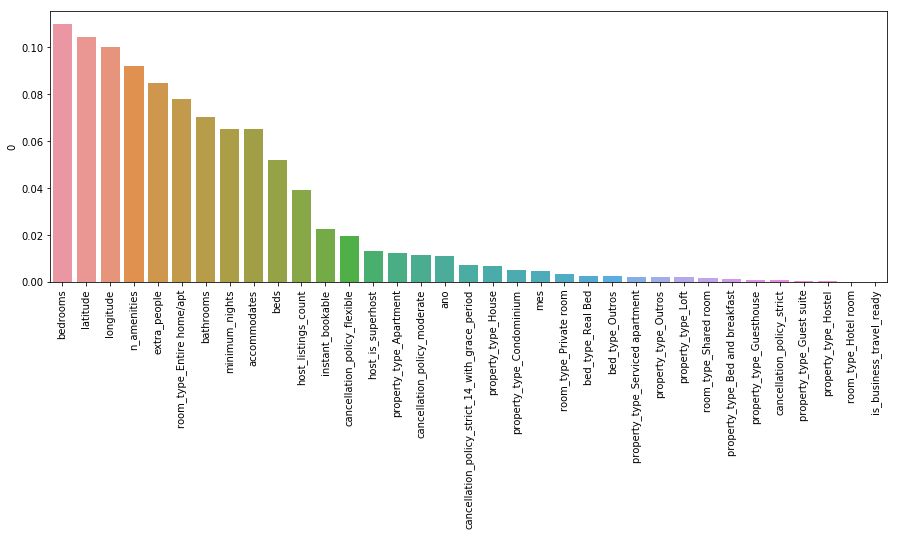

In [63]:
importancia_features = pd.DataFrame(modelo_ext.feature_importances_, X_train.columns)
importancia_features = importancia_features.sort_values(by = 0, ascending = False)
display(importancia_features)

plt.figure(figsize=(15, 5))
ax = sns.barplot(x = importancia_features.index, y = importancia_features[0])
ax.tick_params(axis='x', rotation = 90)

### Ajustes do modelo 

A feature (is_business_travel_ready) não apresentou muita relevância na contrução do modelo. Visando otimizar o modelo escolhido, vou excuir essa feature mencionada e realizar os testes novamente para poder comparar os desempenhos.

Anterior 1 - 
Modelo RandomForest:
R²: 96.69%
RSME: 48.24

Anterior 2 - 
Modelo LinearRegression:
R²: 32.70%
RSME: 217.54

Anterior 3 - 
Modelo ExtraTree:
R²: 97.12%
RSME: 44.98

In [64]:
base_airbnb_cod = base_airbnb_cod.drop('is_business_travel_ready', axis=1)
y = base_airbnb_cod['price']
X = base_airbnb_cod.drop('price', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)

modelo_ext.fit(X_train, y_train)
previsao = modelo_ext.predict(X_test)
print(avaliar_modelo('ExtraTrees', y_test, previsao))

Modelo ExtraTrees:
R²: 97.25%
RSME: 43.99


In [65]:
base_teste = base_airbnb_cod.copy()

for coluna in base_teste:
    if 'bed_type' in coluna:
        base_teste = base_teste.drop(coluna, axis=1)

y = base_teste['price']
X = base_teste.drop('price', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)

modelo_ext.fit(X_train, y_train)
previsao = modelo_ext.predict(X_test)
print(avaliar_modelo('ExtraTrees', y_test, previsao))

Modelo ExtraTrees:
R²: 97.13%
RSME: 44.94


## DEPLOY

In [66]:
X['price'] = y
X.to_csv('Dados Tratados.csv')

In [69]:
! pip install joblib

In [70]:
import joblib
joblib.dump(modelo_ext, 'modelo_airbnb_vf.joblib')

['modelo_airbnb_vf.joblib']